Neste notebook faremos uma rede neural para classificar imagens de digitos manuscritos de 0 a 9:

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import torch.nn as nn

transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="data", train=False, download=True, transform=transform)

Cada elemento em train_dataset, e test_dataset, contém o empacotamento de Tensor representando um numero de 0 a 9,
e a sua label (Qual número ele representa)

In [2]:
train_dataset[0][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [3]:
train_dataset[0][1]

5

Esse registro representa o numero 5:

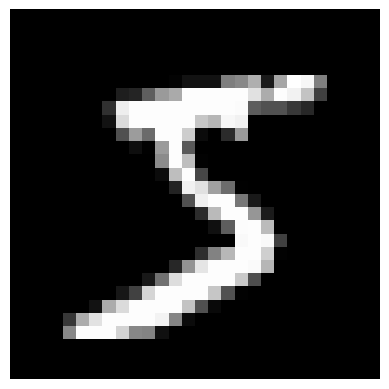

In [4]:
import matplotlib.pyplot as plt

image, label = train_dataset[0]

plt.imshow(image.squeeze(0), cmap="gray")
plt.axis("off")
plt.show()

Temos 60000 digitos manuscritos com 784 pixels cada um (28 x 28):

In [5]:
len(train_dataset), train_dataset[0][0].shape

(60000, torch.Size([1, 28, 28]))

Os valores de pixels ficam entre 0 e 1:

In [6]:
image.min().item(), image.max().item()

(0.0, 1.0)

Temos 10 classes, cada um representando um dos 10 números:

In [7]:
num_classes = len(train_dataset.classes)

num_classes, train_dataset.classes

(10,
 ['0 - zero',
  '1 - one',
  '2 - two',
  '3 - three',
  '4 - four',
  '5 - five',
  '6 - six',
  '7 - seven',
  '8 - eight',
  '9 - nine'])

Separaremos o dataset de treino em batches de 128 imagens cada:

In [8]:
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_batches = len(train_loader)

num_batches

468

In [9]:
x_batch, y_batch = next(iter(train_loader))

x_batch.shape, y_batch.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

Aplicaremos one hot encoding em y:

In [10]:
y_batch_oh = nn.functional.one_hot(y_batch, num_classes)

In [11]:
y_batch_oh[0], y_batch[0]

(tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]), tensor(0))

Definiremos a rede neural, que tera 784 neuronios na camada de entrada (um para cada pixel).

In [12]:
input_dim = x_batch.shape[2] * x_batch.shape[3]
input_dim

784

Tera 10 neuronios na camada de saida, um neuronio para representar a probabilidade de cada digito de 0 a 9:

In [13]:
output_dim = num_classes
output_dim

10

Serão definidas 3 camadas ocultas.

Cada camada oculta tera o numero de neuronios igual a soma do numero de neuronios de entrada e saida dividido por 2, arredondando para cima:

In [14]:
neuronios_oculta1 = int(np.ceil((input_dim + output_dim) / 2))
neuronios_oculta2 = neuronios_oculta1
neuronios_oculta3 = neuronios_oculta2

print(neuronios_oculta1)
print(neuronios_oculta2)
print(neuronios_oculta3)

397
397
397


Define-se o modelo:

OBS: nn.Flatten faz com que a dimensionalidade dos inputs, que é (N, 28, 28), se torne (N, 28*28).

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

#1: Aplica o Flatten para alterar a dimensionalidade de (N, 28, 28), para (N, 28 * 28)
#2: Passa da camada de entrada para a primeira camada oculta
#3: Aplica relu na entrada da primeira camada oculta
#4: Passa da primeira camada oculta para a segunda camada oculta
#5: Aplica relu na entrada da segunda camada oculta
#6: Passa da segunda camada oculta para a terceira camada oculta
#7: Aplica relu na entrada da terceira camada oculta
#8: Passa da terceira camada oculta para a camada de saída.

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        return self.model(x)

model = MLP(input_dim, neuronios_oculta1, output_dim).to(device)
model

MLP(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=397, bias=True)
    (2): ReLU()
    (3): Linear(in_features=397, out_features=397, bias=True)
    (4): ReLU()
    (5): Linear(in_features=397, out_features=397, bias=True)
    (6): ReLU()
    (7): Linear(in_features=397, out_features=10, bias=True)
  )
)

Define-se a função perda e o otimizador:

In [16]:
loss_fn = nn.CrossEntropyLoss()
loss_fn

CrossEntropyLoss()

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.003
    maximize: False
    weight_decay: 0
)

In [18]:
len(train_dataset), len(train_loader)

(60000, 468)

Define-se um step do treinamento, e uma função de teste e começa o treinamento:

In [19]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) #468
    model.train()
    for batch, (X, y) in enumerate(dataloader): #Atribui a X e a y os registros do dataset
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [20]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) #60000
    num_batches = len(dataloader) #468
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [21]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    test(test_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.306189  [  128/60000]
loss: 0.227431  [12928/60000]
loss: 0.173904  [25728/60000]
loss: 0.155050  [38528/60000]
loss: 0.128558  [51328/60000]
Test Error: 
 Accuracy: 95.7%, Avg loss: 0.138243 

Epoch 2
-------------------------------
loss: 0.197825  [  128/60000]
loss: 0.107787  [12928/60000]
loss: 0.155898  [25728/60000]
loss: 0.052835  [38528/60000]
loss: 0.154561  [51328/60000]
Test Error: 
 Accuracy: 97.1%, Avg loss: 0.096341 

Epoch 3
-------------------------------
loss: 0.082704  [  128/60000]
loss: 0.113760  [12928/60000]
loss: 0.034439  [25728/60000]
loss: 0.069572  [38528/60000]
loss: 0.125976  [51328/60000]
Test Error: 
 Accuracy: 96.9%, Avg loss: 0.104869 

Epoch 4
-------------------------------
loss: 0.025774  [  128/60000]
loss: 0.025975  [12928/60000]
loss: 0.062567  [25728/60000]
loss: 0.042495  [38528/60000]
loss: 0.075990  [51328/60000]
Test Error: 
 Accuracy: 96.9%, Avg loss: 0.104603 

Epoch 5
------------------------

Com a rede neural treinada, vamos testar se ela está reconhecendo digitos:

In [26]:
model.eval()
with torch.no_grad():
    x = test_dataset[0][0].to(device)
    print(np.argmax(torch.softmax(model(x), dim = 1).cpu().numpy()))

7


In [23]:
test_dataset[0][1]

7